# Описание проекта
Заказчик этого исследования — большая компания 'A', которая оказывает услуги на территории всего СНГ. Перед компанией стоит задача определить текущий уровень потребительской лояльности, или NPS, среди клиентов из России. 
Чтобы определить уровень лояльности, клиентам задавали классический вопрос: «Оцените по шкале от 1 до 10 вероятность того, что вы порекомендуете компанию друзьям и знакомым».

Компания провела опрос, и теперь **необходимо создать дашборд с его итогами**. Большая база данных для этой задачи развернута не была, данные выгружены в SQLite. 

Чтобы оценить результаты опроса, оценки обычно делят на три группы:
9-10 баллов — «cторонники» (англ. promoters);
7-8 баллов — «нейтралы» (англ. passives);
0-6 баллов — «критики» (англ. detractors).
Итоговое значение NPS рассчитывается по формуле: % «сторонников» - % «критиков».
Таким образом, значение этого показателя варьируется от -100% (когда все клиенты «критики») до 100% (когда все клиенты лояльны к сервису). 


С помощью дашборда необходимо ответить на следующие вопросы:

- Как распределены участники опроса по возрасту и полу? 
- Каких пользователей больше: новых или старых? Пользователи из каких городов активнее участвовали в опросе?
- Какие группы пользователей наиболее лояльны к сервису? Какие менее?
- Какой общий NPS среди всех опрошенных?
- Как можно описать клиентов, которые относятся к группе cторонников (англ. promoters)?

Описание данных будет представлено после их выгрузки из базы данных.

> Ограничения и цель анализа
>
> Данный анализ основан на выборочных данных, полученных в результате опроса клиентов. Несмотря на большой объем выборки, она не обязательно полностью отражает структуру всей клиентской базы компании. Все выводы, визуализации и расчеты (в том числе значение NPS и сравнения между группами) относятся только к этой выборке и не могут быть автоматически распространены на всю генеральную совокупность без дополнительной проверки статистической значимости и репрезентативности.
>
> Цель данной работы — провести предварительный анализ, выявить основные тренды, проблемные сегменты и сформулировать гипотезы для дальнейшего, более глубокого исследования. Для принятия стратегических решений или публикации результатов рекомендуется дополнительно провести статистические тесты, рассчитать доверительные интервалы и убедиться в репрезентативности данных.

Работа будет проведена в три этапа:
1. Соединение с базой данных и выгрузка необходимых данных с помощью SQL запроса, создание датасета.
2. Предобработка данных и EDA в ноутбуке с использованием библиотек python, выгрузка данных.
3. Построение серии интерактивных дашбордов ('story') и отдельных интерактивных графиков в Tableau. Описание наблюдений на дашбордах.


Импортируем необходимые библиотеки перед началом работы:

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from sqlalchemy import create_engine

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", mat.__version__)
print("seaborn:", sns.__version__)


pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.9.2
seaborn: 0.13.2


# Создание соединения и SQL-запрос

> **Подключение к базе данных**
>
> В этой ячейке указывается путь к файлу базы данных SQLite и создается объект `engine` с помощью SQLAlchemy. Этот объект используется для выполнения SQL-запросов и загрузки данных из базы в pandas DataFrame.

In [3]:
path_to_db= r"C:\Users\aprok\Downloads\telecomm_csi.db"

if path_to_db:
    engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

Пишем sql запрос, позволяющий достать из базы данных только нужную информацию в необходимом формате.

In [4]:
query = """

WITH 
    age AS (SELECT age_gr_id, title FROM age_segment),
    
    traffic AS (SELECT tr_gr_id, title FROM traffic_segment),
    
    lifetime AS (SELECT lt_gr_id, title FROM lifetime_segment)


SELECT user.user_id, user.lt_day, 
    CASE 
        WHEN user.lt_day <= 365 THEN 'new'
        ELSE 'old'
    END AS is_new ,
user.age, 
    CASE 
        WHEN user.gender_segment = 1 THEN 'woman'
        WHEN user.gender_segment = 0 THEN 'man'
        Else 'Others'
    END AS gender
, user.os_name, user.cpe_type_name, location.country, location.city, age.title AS age_segmen, traffic.title AS traffic, lifetime.title AS lifetime_segment, user.nps_score,
    CASE 
        WHEN user.nps_score >= 9 THEN 'promoters'
        WHEN user.nps_score >= 7 AND user.nps_score < 9 THEN 'neutrals'
        WHEN user.nps_score >= 0 AND user.nps_score < 7 THEN 'detractors' 
    END AS nps_segment

FROM user JOIN location ON user.location_id = location.location_id JOIN age ON user.age_gr_id = age.age_gr_id JOIN traffic ON user.tr_gr_id = traffic.tr_gr_id JOIN lifetime ON user.lt_gr_id = lifetime.lt_gr_id

"""


# Предобработка данных

Из базы данных формируем датасет, соответствующий запросу

In [5]:
df = pd.read_sql(query, engine)


**Описание получишвегося датасета**

- user_id -	Идентификатор клиента
- lt_day - Количество дней «жизни» клиента
- is_new - Поле хранит информацию о том, является ли клиент новым
- age - Возраст
- gender_segment - Пол 
- os_name - Тип операционной системы
- cpe_type_name - Тип устройства
- country - Страна проживания
- city - Город проживания
- age_segment - Возрастной сегмент
- traffic_segment - Сегмент по объёму потребляемого трафика
- lifetime_segment - Сегмент по количеству дней «жизни»
- nps_score - Оценка клиента в NPS-опросе
- nps_group - Поле хранит информацию о том, к какой группе относится оценка клиента в опросе

Смотрим основную информацию о датасете.

In [6]:
print(df.head(5))

  user_id  lt_day is_new   age gender  os_name cpe_type_name country  \
0  A001A2    2320    old  45.0  woman  ANDROID    SMARTPHONE  Россия   
1  A001WF    2344    old  53.0    man  ANDROID    SMARTPHONE  Россия   
2  A003Q7     467    old  57.0    man  ANDROID    SMARTPHONE  Россия   
3  A004TB    4190    old  44.0  woman      IOS    SMARTPHONE  Россия   
4  A004XT    1163    old  24.0    man  ANDROID    SMARTPHONE  Россия   

           city age_segmen   traffic lifetime_segment  nps_score nps_segment  
0           Уфа   05 45-54    04 1-5           08 36+         10   promoters  
1         Киров   05 45-54    04 1-5           08 36+         10   promoters  
2        Москва   06 55-64  08 20-25         06 13-24         10   promoters  
3  РостовнаДону   04 35-44  03 0.1-1           08 36+         10   promoters  
4        Рязань   02 16-24   05 5-10           08 36+         10   promoters  


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502493 entries, 0 to 502492
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           502493 non-null  object 
 1   lt_day            502493 non-null  int64  
 2   is_new            502493 non-null  object 
 3   age               501939 non-null  float64
 4   gender            502493 non-null  object 
 5   os_name           502493 non-null  object 
 6   cpe_type_name     502493 non-null  object 
 7   country           502493 non-null  object 
 8   city              502493 non-null  object 
 9   age_segmen        502493 non-null  object 
 10  traffic           502493 non-null  object 
 11  lifetime_segment  502493 non-null  object 
 12  nps_score         502493 non-null  int64  
 13  nps_segment       502493 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 53.7+ MB


Избавимся от индексов категорий

In [8]:
df['age_segmen'] = df['age_segmen'].str.split(pat=' ').str[1]
df['age_segmen'] = df['age_segmen'].str.replace('до', 'до 16')
df['traffic'] = df['traffic'].str.split(pat=' ').str[1]
df['lifetime_segment'] = df['lifetime_segment'].str.split(pat=' ').str[1]


In [9]:
print(df['age_segmen'].unique(), ' ', df['traffic'].unique(), ' ', df['lifetime_segment'].unique(), ' ', sep = '\n')

['45-54' '55-64' '35-44' '16-24' '25-34' '66' 'до 16' 'n/a']
 
['1-5' '20-25' '0.1-1' '5-10' '10-15' '45-50' '15-20' '25-30' '40-45'
 '75-80' '50-55' '85-90' '60-65' '70-75' '30-35' '80-85' '100+' '35-40'
 '55-60' '90-95' '65-70' '0.01-0.1' '95-100' '0-0.01' '0']
 
['36+' '13-24' '7-12' '4-6' '25-36' '2' '3' '1']
 


## Проверка категориальных значений

Посмотрим, какие значения принимают категориальные переменные. Убедимся, что среди них нет подозрительных или неявно дублирующих друг друга.

In [10]:
#df['age_segmen'].unique()
#df['traffic'].unique()
#df['lifetime_segment'].unique()

In [11]:
print(df['os_name'].unique(), ' ', df['cpe_type_name'].unique(), ' ', df['city'].unique(), ' ', sep = '\n')
print(df['country'].unique())


['ANDROID' 'IOS' 'OTHER' 'unknown' 'PROPRIETARY' 'WINDOWS PHONE'
 'SYMBIAN OS' 'BADA OS' 'WINDOWS MOBILE']
 
['SMARTPHONE' 'TABLET' 'MOBILE PHONE/FEATURE PHONE' 'PHONE' 'ROUTER'
 'MODEM' 'WLAN ROUTER' 'USB MODEM' 'unknown' 'PORTABLE(INCLUDE PDA)'
 'NETWORK DEVICE' 'MIFI ROUTER' 'MOBILE TEST PLATFORM' 'HANDHELD']
 
['Уфа' 'Киров' 'Москва' 'РостовнаДону' 'Рязань' 'Омск' 'СанктПетербург'
 'Волгоград' 'Тольятти' 'Казань' 'Самара' 'Красноярск' 'Екатеринбург'
 'Калуга' 'Краснодар' 'Иркутск' 'Пермь' 'Владимир' 'Ижевск' 'Тюмень'
 'Оренбург' 'НижнийНовгород' 'Брянск' 'Челябинск' 'Астрахань' 'Сургут'
 'Тверь' 'Новосибирск' 'НабережныеЧелны' 'Махачкала' 'Воронеж' 'Курск'
 'Владивосток' 'Балашиха' 'Пенза' 'Калининград' 'Тула' 'Саратов'
 'Кемерово' 'Белгород' 'Барнаул' 'Чебоксары' 'Архангельск' 'Томск'
 'Ярославль' 'Ульяновск' 'Хабаровск' 'Грозный' 'Ставрополь' 'Липецк'
 'Новокузнецк' 'Якутск' 'УланУдэ' 'Сочи' 'Иваново' 'НижнийТагил'
 'Смоленск' 'Волжский' 'Магнитогорск' 'Чита' 'Череповец' 'Саранск

In [12]:
df['cpe_type_name'].value_counts()

cpe_type_name
SMARTPHONE                    487959
TABLET                          9274
PHONE                           2531
MOBILE PHONE/FEATURE PHONE      2471
ROUTER                           196
USB MODEM                         27
unknown                           18
MODEM                              7
WLAN ROUTER                        3
NETWORK DEVICE                     3
PORTABLE(INCLUDE PDA)              1
MIFI ROUTER                        1
MOBILE TEST PLATFORM               1
HANDHELD                           1
Name: count, dtype: int64

Обработка категориальных данных, за исключением уже проведенной ранее (с индексами сегментов), не требуется.

## Проверка количественных значений и EDA

Задачи этого раздела:
1. Посмотреть на основные распределения 
2. Изучить аномалии и обработать их при необходимости
3. Сформировать первичное представление о данных, получить первые инсайты и начертить гипотезы для более детального анализа в Tableau.

Посмотрим на описание данных и распределения колич. переменных.

              lt_day            age      nps_score
count  502476.000000  501939.000000  502476.000000
mean     1868.904911      39.621946       7.508607
std      1683.694880      11.188249       3.020376
min         1.000000      10.000000       1.000000
25%       533.000000      31.000000       5.000000
50%      1239.000000      38.000000       9.000000
75%      3064.000000      47.000000      10.000000
max      9162.000000      89.000000      10.000000


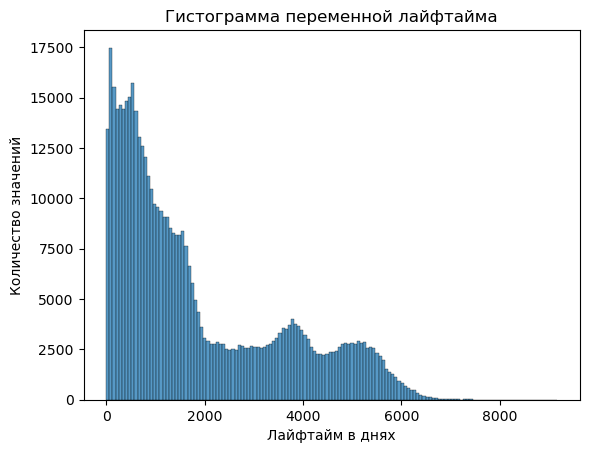

In [43]:
print(df.describe())
sns.histplot(df, x = 'lt_day')
plt.title('Гистограмма переменной лайфтайма')
plt.xlabel('Лайфтайм в днях')
plt.ylabel('Количество значений')
plt.show()


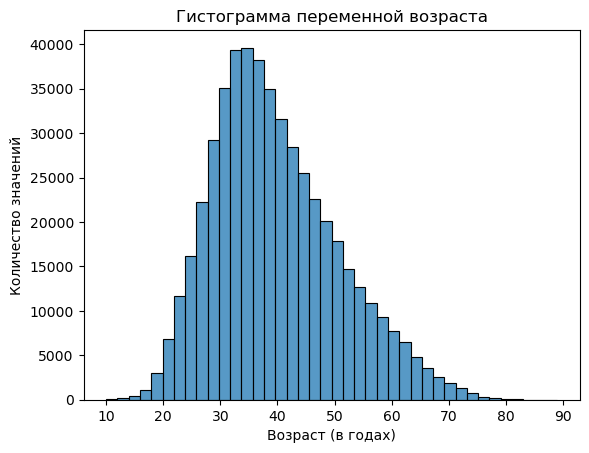

In [44]:
sns.histplot(df, x = 'age', bins = 40)
plt.title('Гистограмма переменной возраста')
plt.xlabel('Возраст (в годах)')
plt.ylabel('Количество значений')
plt.show()

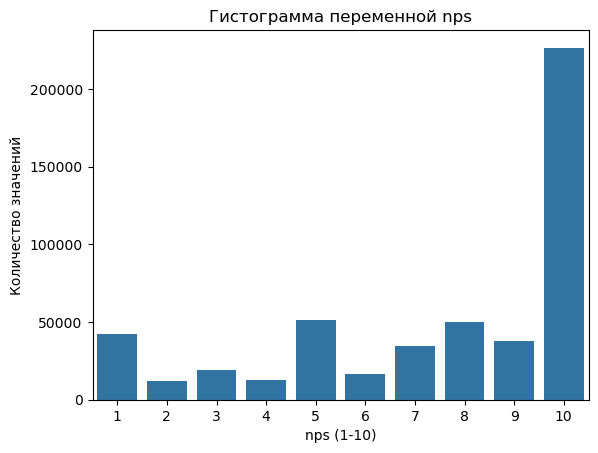

In [56]:
nps_cnt = df.groupby('nps_score')['user_id'].count().reset_index()

sns.barplot(nps_cnt, x = 'nps_score', y = 'user_id')
plt.title('Гистограмма переменной nps')
plt.xlabel('nps (1-10)')
plt.ylabel('Количество значений')
plt.show()

Выявлены аномальные строки с отрицательными значениями lt. Такие строки будут удалены.

In [14]:
df = df[df['lt_day'] > 0]



Теперь взглянем на ящики с усами, которые показывают медианы и разброс значений, а также визуализируют статистические выбросы.

In [15]:
def boxpl(col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[col], orient='h')
    plt.title(f'Boxplot для {col}')
    plt.show()

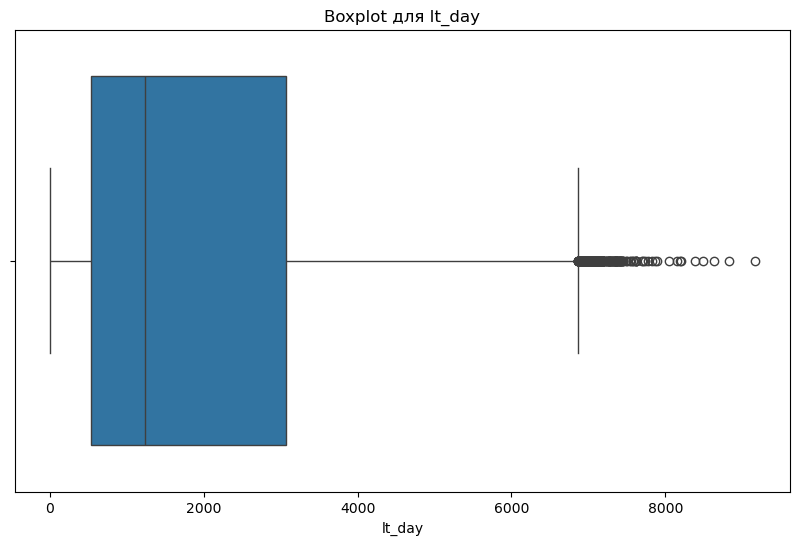

In [16]:
boxpl('lt_day')

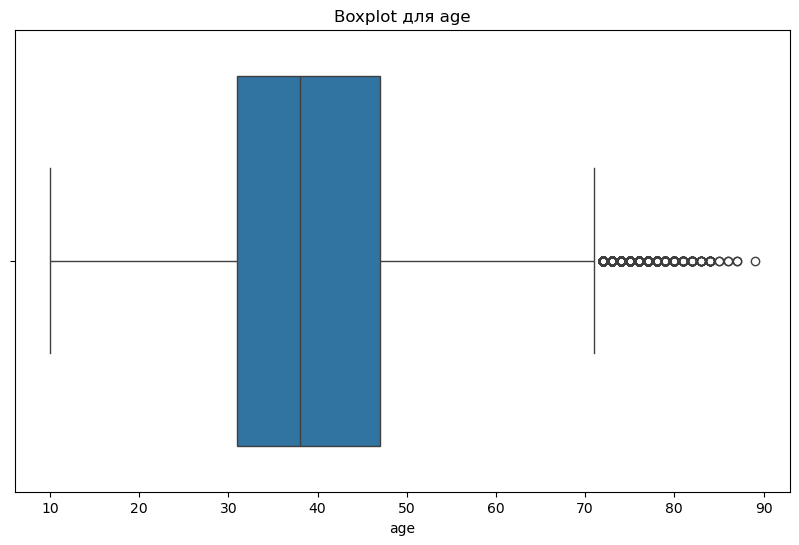

In [17]:
boxpl('age')

Есть стат. выбросы для переменных возраста и лайфтайма, но содержательных причин для их обработки нет.

In [18]:
df['nps_score'].median()

9.0

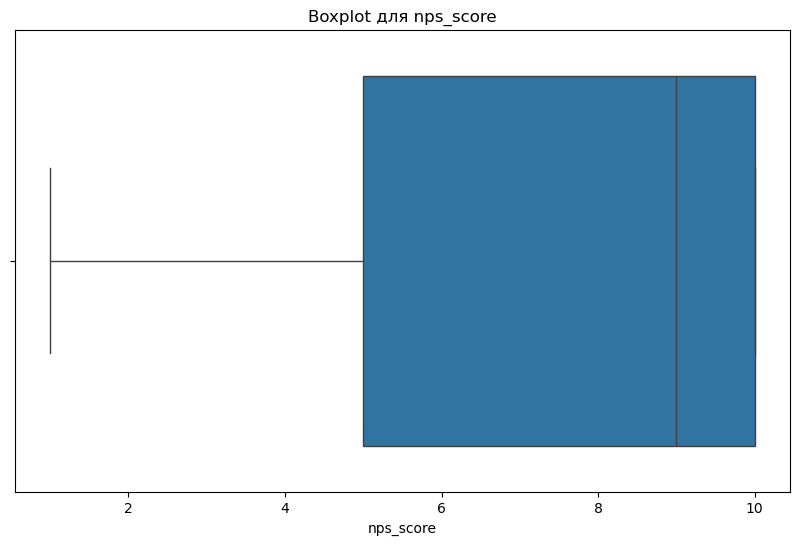

In [19]:
boxpl('nps_score')

Примерно 50% значений лояльности лежит в диапазоне от 5 до 10. Медиана равна 9.

In [20]:
df.groupby('age_segmen')['nps_score'].median()

age_segmen
16-24     8.0
25-34     8.0
35-44     9.0
45-54    10.0
55-64    10.0
66       10.0
n/a       3.0
до 16     7.0
Name: nps_score, dtype: float64

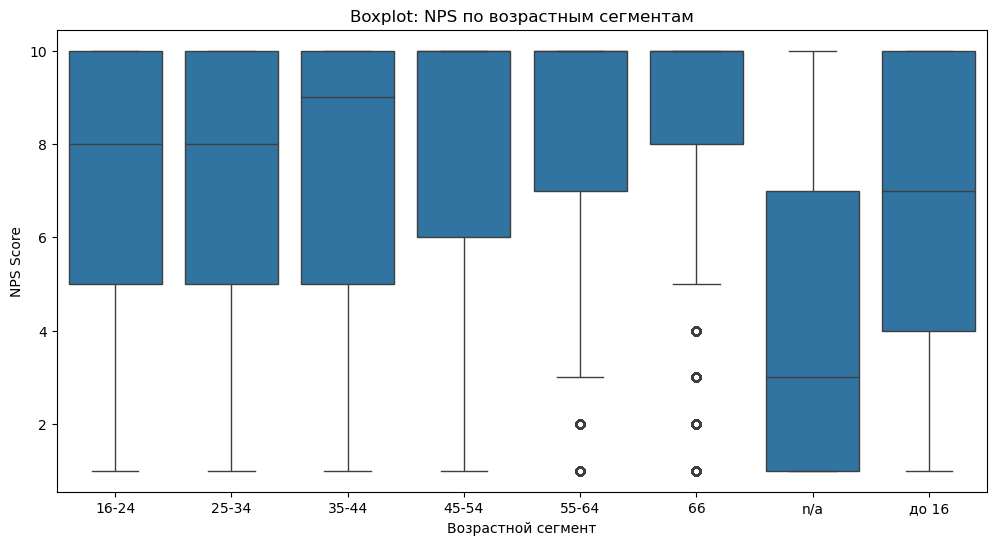

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_segmen', y='nps_score', data=df, order=sorted(df['age_segmen'].unique()))
plt.title('Boxplot: NPS по возрастным сегментам')
plt.xlabel('Возрастной сегмент')
plt.ylabel('NPS Score')
plt.show()

Медиана nps в обобщенной категории 45-66 равна 10. Предварительно, клиенты этой возрастной категории наиболее лояльны компании. В то же время, минимальная медиана наблюдается в категории до 16.

Выбросы, отображенные на графиках, не вызывают содержательных подозрений.

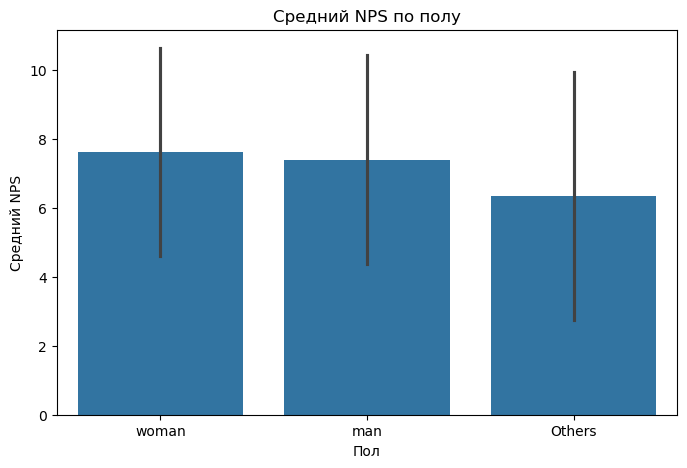

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(x='gender', y='nps_score', data=df, estimator=np.mean, errorbar ='sd')
plt.title('Средний NPS по полу')
plt.xlabel('Пол')
plt.ylabel('Средний NPS')
plt.show()

NPS в разрезе пола практически не различается. Что касается others, то таких значений попросту сильно меньше, так что колебания среднего допустимы.

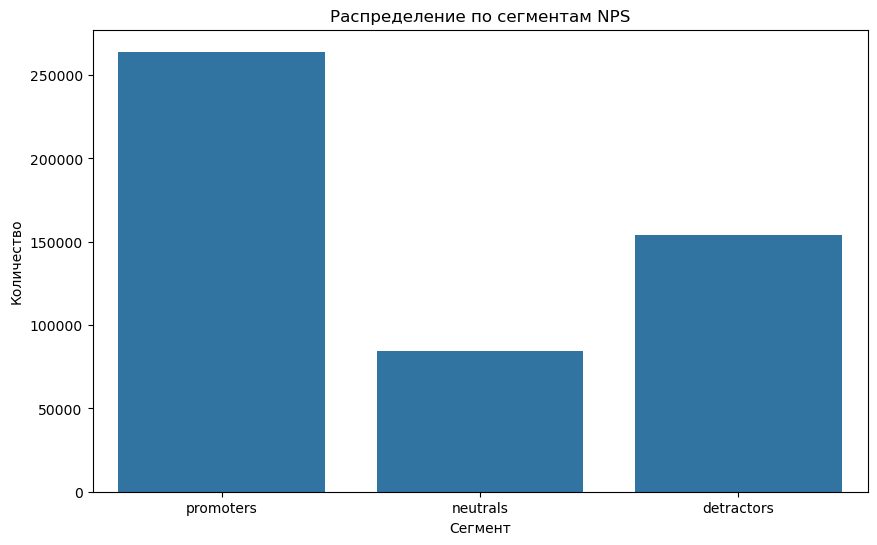

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='nps_segment', data=df, order=['promoters', 'neutrals', 'detractors'])
plt.title('Распределение по сегментам NPS')
plt.xlabel('Сегмент')
plt.ylabel('Количество')
plt.show()

Видим, что в компании преобладает число сторонников. Критиков на 100 тыс. меньше (примерно на 40%).
Нейтралов меньше всего - примерно втрое меньше, чем сторонников.

График ниже показывает города с наибольшим числом участников опроса. Это помогает выявить географические перекосы в выборке.



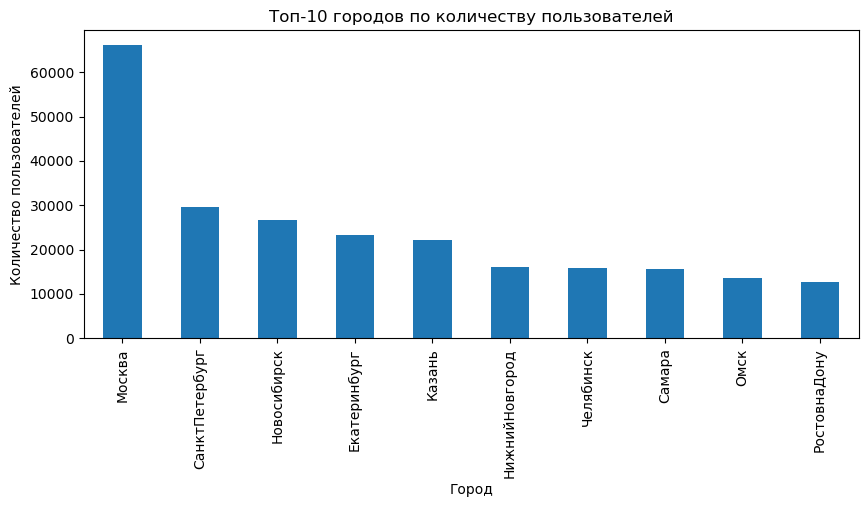

In [24]:
df['city'].value_counts().head(10).plot(kind='bar', figsize=(10,4), title='Топ-10 городов по количеству пользователей')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

Видим, что в выборке прежде всего представлены Москва и крупные города-миллионники. 

Посмотрим корреляционную матрицу количественных переменных.

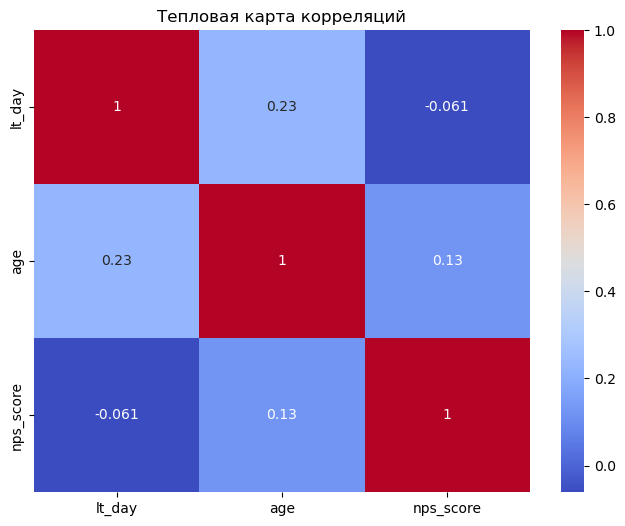

In [25]:
# Корреляционная матрица по числовым признакам
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляций')
plt.show()

Предварительно, есть связь между возрастом и lifetime, но она предсказуема. О каких-то значимых ограничениях или инсайтах матрица не свидетельствует. Можно, разве что, сказать о слабой положительной линейной зависимости между возрастом и значением лояльности.

Выводы по колич. данным и EDA:

1. Основные распределения и параметры количественных столбцов изучены.
2. Обработать потребовалось только отрицательные значения в столбце lifetime (строки были удалены)
3. В комментариях под визуализациями были сделаны первые наблюдения и предварительные выводы по ним.
4. Выборка скошена в сторону больших городов, но это вполне может соответствовать структуре генеральной совокупности. Требуется дополнительная информация от заказчика, чтобы сделать из этого наблюдения какой-то вывод.
5. После обработки данные не вызывают подозрений и не несут с собой никаких значимых ограничений.

## Удаление дубликатов

In [26]:
print(len(df))
df = df.drop_duplicates()
len(df)

502476


502476

Явных дубликатов обнаружено не было. 

## Переименование столбцов

In [27]:
data = df
data = data.rename(columns={"gender":"Gender"})

Предобработка и EDA завершены. 

Сохраним получившиеся таблицы как csv файлы.

In [28]:
df.to_csv('telecomm_csi_tableau.csv', index=False)
data[['user_id', 'Gender']].to_csv('telecomm_csi_tableau_gender.csv', index=False)


# Общий NPS и дов. интервал

NB: NPS считается как процент сторонников компании вычесть процент критиков.

Построим доверительный интервал для главной метрики - общего NPS.

In [29]:
n = len(df)
n_promoters = (df['nps_segment'] == 'promoters').sum()
n_detractors = (df['nps_segment'] == 'detractors').sum()

p_promoters = n_promoters / n
p_detractors = n_detractors / n
nps = p_promoters - p_detractors

alpha = 0.01  # 99% доверительный интервал
# Используем нормальное приближение, так как интервал строится для доли (разности долей) и данных много.
se = np.sqrt(p_promoters * (1 - p_promoters) / n + p_detractors * (1 - p_detractors) / n)
from scipy.stats import norm
z = norm.ppf(1 - alpha/2)
ci_low = nps - z * se
ci_high = nps + z * se

print(f"95% доверительный интервал: [{ci_low * 100:.3f}, {ci_high * 100 :.3f}]", f'Выборочный NPS: {round(nps*100, 3)}', sep = '\n')

95% доверительный интервал: [21.653, 22.147]
Выборочный NPS: 21.9


Значит, истинное значение общего NPS, с 99 процентной вероятностью, лежит в диапазоне от 21.65 до 22.15%.
Выборочный NPS же равен 21.9.

# Визуализация в Tableau и выводы

Для просмотра дашборда необходима открыть его по ссылке ниже. Он опубликован в tebleau public. Советую развернуть его во весь экран, чтобы графики и выводы отображались полностью.

Помимо основного дашборда (а точнее трех, связанных в одну историю), в этом проекте есть и другие сопутствующие графики. Чтобы посмотреть их, переключайте листы вверху страницы.

Как и дашборды, так и графики интерактивны. Нажимайте на столбцы или части диаграмм другой формы, чтобы изменить скоуп данных для визуализации, а также используйте ползунки, при их наличии.

https://public.tableau.com/app/profile/alex.prokof/viz/NPSproject_16939514575260/Story1?publish=yes